<a href="https://colab.research.google.com/github/ospinooo/mushsnap-research/blob/master/MushSnap_Image_Classification_FineTunning_Augmentation_Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Which GPU?
!nvidia-smi

Mon Jun 22 11:01:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 450kB 57.4MB/s 
     |████████████████████████████████| 3.9MB 50.0MB/s 
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [3]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.1.0


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

## Kaggle Configuration

In [7]:
# Install and activate kaggle
!pip install -q --upgrade kaggle
!mkdir -p ~/.kaggle
!cp drive/'My Drive'/'final project'/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### Kaggle Data

In [8]:
# Download
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
# Unzip dataset
!unzip -q mushrooms-classification-common-genuss-images.zip
!ls

100% 1.85G/1.85G [00:31<00:00, 41.7MB/s]

drive	   Mushrooms					      sample_data
mushrooms  mushrooms-classification-common-genuss-images.zip


In [10]:
# Reading all paths
ALL_IMG_PATHS = list(paths.list_images("Mushrooms"))
ALL_IMG_PATHS = [i for i in ALL_IMG_PATHS if i.split("/")[2][0] != '.']
# Shuffle image paths and preview
random.seed(1)
random.shuffle(ALL_IMG_PATHS)
print(ALL_IMG_PATHS[:5])
print(f" Total number of images: {len(ALL_IMG_PATHS)}")

['Mushrooms/Lactarius/0335_dVTfQmjMltw.jpg', 'Mushrooms/Agaricus/315_QKC0Z00asXo.jpg', 'Mushrooms/Lactarius/238_W7LT7dc1IE4.jpg', 'Mushrooms/Boletus/0624_RmlDHXvJUeU.jpg', 'Mushrooms/Lactarius/1190_rr9UnE6S67U.jpg']
 Total number of images: 6714


100%|██████████| 50/50 [00:01<00:00, 45.86it/s]


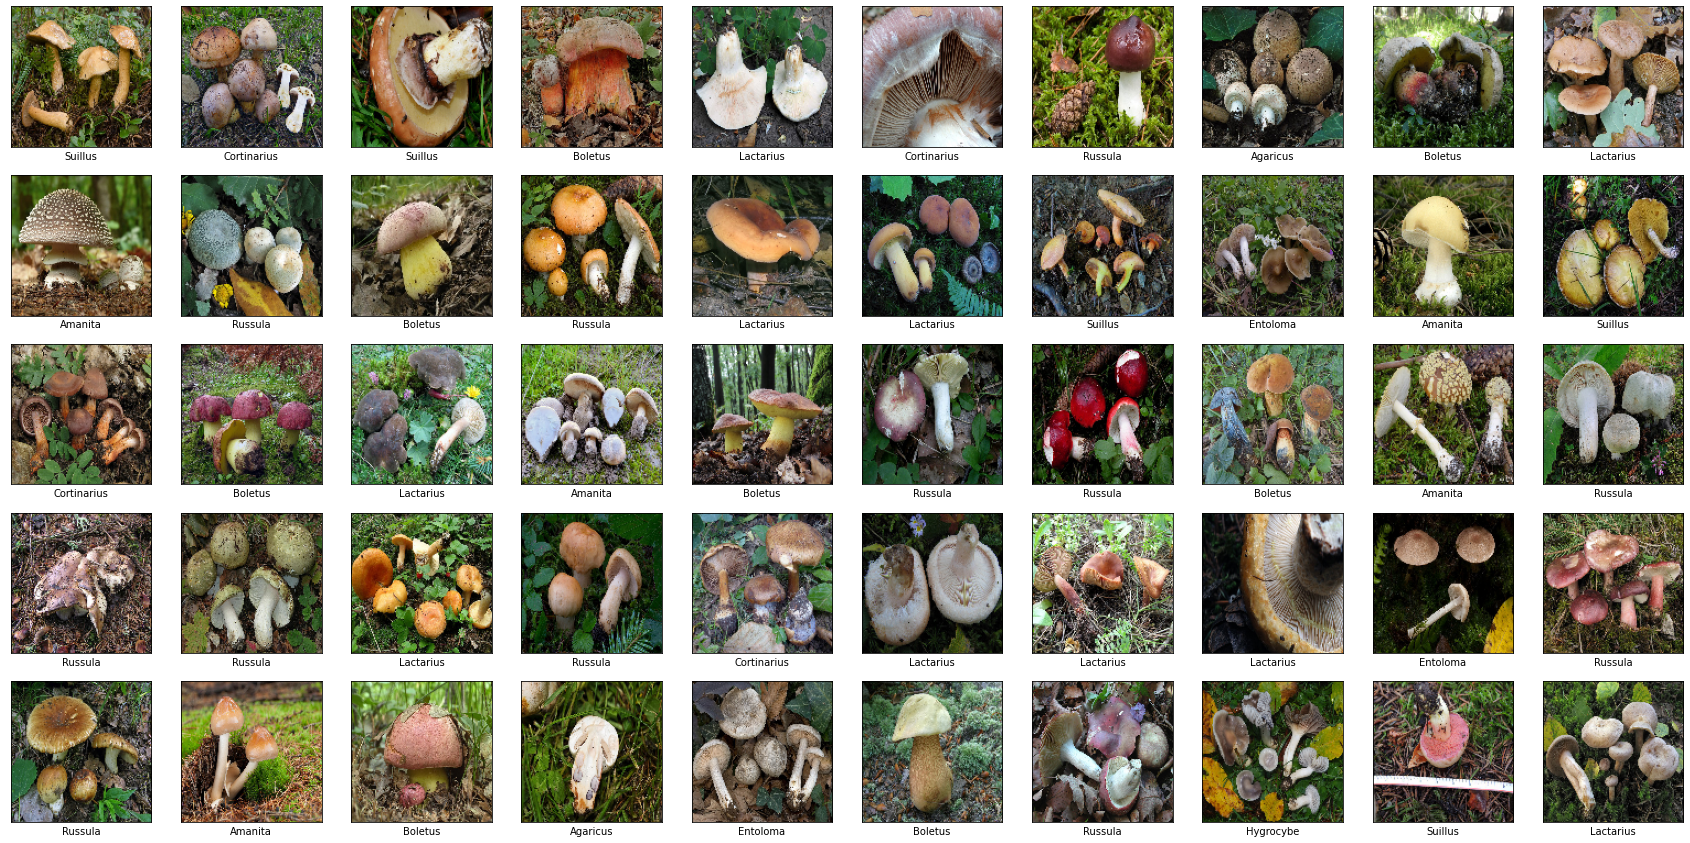

In [11]:
# Visualize images
plt.figure(figsize=(30,15))
for i in tqdm(range(50)):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [12]:
# Split
percentage_test = 0
percentage_val = 0.2

# Total images per subset
nb_val_images_i = int(len(ALL_IMG_PATHS) * percentage_val)
nb_test_images_i = int(len(ALL_IMG_PATHS) * percentage_test)
nb_train_images_i = len(ALL_IMG_PATHS) - (nb_val_images_i + nb_test_images_i)

# Create tuples extremes for each subset
nb_train_images = 0, nb_train_images_i
nb_val_images = nb_train_images_i, nb_train_images_i + nb_val_images_i
nb_test_images = nb_train_images_i + nb_val_images_i,  len(ALL_IMG_PATHS)


print(nb_train_images)
print(nb_val_images)
print(nb_test_images)

(0, 5372)
(5372, 6714)
(6714, 6714)


In [13]:
# Specify the directory paths
train_dir = "train"
val_dir = "val"
test_dir = "test"

In [14]:
def move_images(nb_images, output_dir):

    # iterate through the number of images
    for i in tqdm(range(*nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [16]:
!rm -rf train
!rm -rf val
!rm -rf test

In [17]:
# Prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_val_images, val_dir)
move_images(nb_test_images, test_dir)

100%|██████████| 1342/1342 [00:00<00:00, 1635.46it/s]
0it [00:00, ?it/s]


['Cortinarius', 'Agaricus', 'Entoloma', 'Amanita', 'Boletus', 'Hygrocybe', 'Russula', 'Lactarius', 'Suillus']


<BarContainer object of 9 artists>

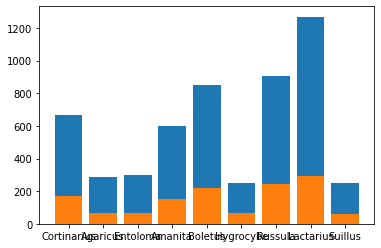

In [18]:
# Plot the sizes of every class

x_labels = os.listdir("Mushrooms")
print(x_labels)

plt.bar(x_labels, height=[len(list(paths.list_images(os.path.join(train_dir, i)))) for i in x_labels])
plt.bar(x_labels, height=[len(list(paths.list_images(os.path.join(val_dir, i)))) for i in x_labels])
plt.bar(x_labels, height=[len(list(paths.list_images(os.path.join(test_dir, i)))) for i in x_labels])

In [19]:
from tensorflow.keras.applications.xception import preprocess_input
BATCH_SIZE = 32
# Setup data generators
train_aug = ImageDataGenerator(preprocessing_function=preprocess_input
                               , zoom_range=0.3
                               , rotation_range=40
                               , width_shift_range=0.2
                               , height_shift_range=0.2
                               , shear_range=0.2
                               , horizontal_flip=True
                               , fill_mode='nearest'
                               )

val_aug = ImageDataGenerator(
    # rescale=1/255.
    preprocessing_function=preprocess_input
    )

size = (224, 224)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=size,
		color_mode="rgb",
		shuffle=True,
		batch_size=BATCH_SIZE
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=size,
		color_mode="rgb",
		shuffle=False,
		batch_size=BATCH_SIZE
)

Found 5372 images belonging to 9 classes.
Found 1342 images belonging to 9 classes.


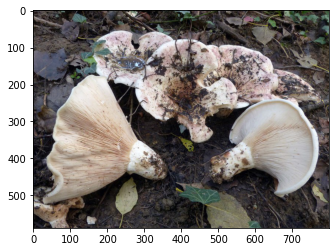

In [22]:
plt.imshow(load_img(ALL_IMG_PATHS[0]))

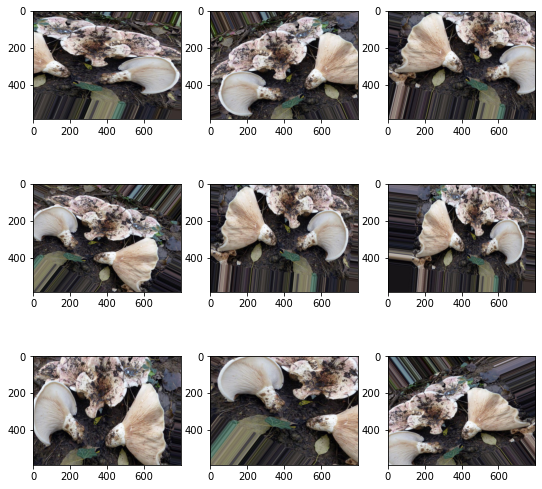

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

!mkdir preview
!rm -rf preview/*

img = load_img(ALL_IMG_PATHS[0])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_aug.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely

plt.figure(figsize=(9,9))
k = 0
for i in os.listdir('preview'):
    img = plt.imread('preview' + os.sep + i)
    plt.subplot(3,3,k+1)
    k += 1
    plt.imshow(img)

In [23]:
print (train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('mushroom_labels.txt', 'w') as f:
    f.write(labels)

{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


In [24]:
!cat mushroom_labels.txt

Agaricus
Amanita
Boletus
Cortinarius
Entoloma
Hygrocybe
Lactarius
Russula
Suillus

## Training

In [25]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras.applications.xception import Xception

In [26]:
# Load the model but exclude the classification layers
EXTRACTOR = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

EXTRACTOR.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [27]:
def get_training_model():
    # We are fine-tuning the extractor model
    EXTRACTOR.trainable = True
    for layer in EXTRACTOR.layers[:-(12*2)]:
        layer.trainable = False
    
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)

    class_head = Dense(1024, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)

    class_head = Dense(1024, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)

    class_head = Dense(512, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)

    class_head = Dense(512, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)

    class_head = Dense(256, activation="relu")(class_head)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.5)(class_head)
    
    class_head = Dense(9, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier


### Learning rate

Since we are fine-tuning a pre-trained network it'd be prudent to not break the weights of that pre-trained network too fast. So the idea is to start with a relatively lower learning rate and then increase it gradually.

In [28]:
# LR schedule configuration
start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.001
rampup_epochs = 15
sustain_epochs = 0
exp_decay = .8

In [29]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

0.0001 0.00013958241859993604


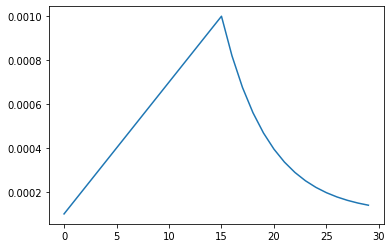

In [30]:
# How does the LR schedule looks like?
rng = [i for i in range(30)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [31]:
n_train_samples = len(list(paths.list_images("train")))
n_val_samples = len(list(paths.list_images("val")))

n_train_samples, n_val_samples

(5372, 1342)

### Training

In [32]:
# Solve error of loading truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
# Train the model
mushroom_model = get_training_model()

tbCallBack = TensorBoard(
    log_dir='./log', histogram_freq=1,
    write_graph=True,
    write_images=True)

earlystop_callback = EarlyStopping(
  monitor='val_loss',
  patience=10)

start = time.time()
history = mushroom_model.fit(train_gen,
              steps_per_epoch=n_train_samples//BATCH_SIZE,
              validation_data=val_gen,
              validation_steps=n_val_samples//BATCH_SIZE,
              epochs=30,
              callbacks=[lr_callback])
print("Total training time: ",time.time()-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 167 steps, validate for 41 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
167/167 [==============================] - 137s 818ms/step - loss: 3.4093 - accuracy: 0.1313 - val_loss: 2.5670 - val_accuracy: 0.1166

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00016.
Epoch 2/30
167/167 [==============================] - 127s 758ms/step - loss: 3.1888 - accuracy: 0.1358 - val_loss: 2.3247 - val_accuracy: 0.1174

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00022.
Epoch 3/30
167/167 [==============================] - 127s 760ms/step - loss: 2.8770 - accuracy: 0.1788 - val_loss: 1.9483 - val_accuracy: 0.2637

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00028000000000000003.
Epoch 4/30
167/167 [==============================] - 127s 759ms/step - loss: 2.5347 - accuracy: 0.2438 - val_loss: 1.9185 - val_accuracy: 0.3613

Epoch 00005: LearningRat

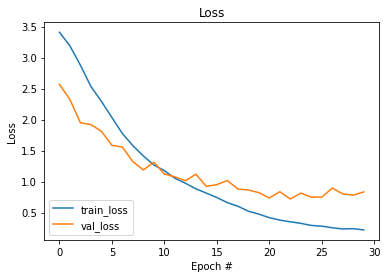

In [34]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

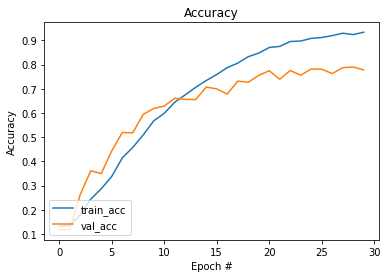

In [35]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()